In [35]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

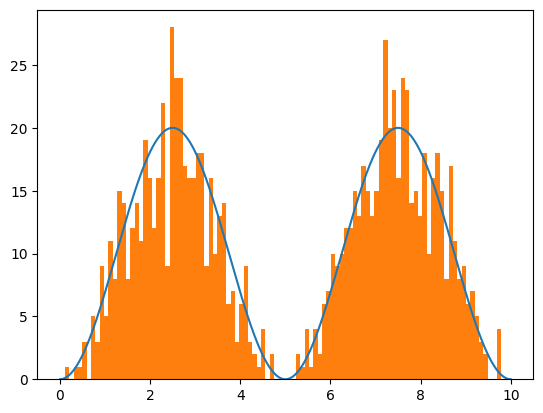

In [95]:
# I thought this would be a cool distribution

def sine_squared(x, wavelength, cutoff):
    A = 1/((cutoff/2)-(np.sin(4*np.pi*cutoff/wavelength)/(8*np.pi)))
    y = A * np.sin(2*np.pi*x/wavelength)**2
    return y

def sample_sine_squared_vectorized(wavelength, cutoff, n_samples):
    norm = (cutoff / 2) - (wavelength / (8 * np.pi)) * np.sin(4 * np.pi * cutoff / wavelength)
    pdf_max = 1 / norm
    samples = []
    batch_size = max(1000, n_samples)
    while len(samples) < n_samples:
        x = np.random.uniform(0, cutoff, size=batch_size)
        y = np.random.uniform(0, pdf_max, size=batch_size)
        accepted = x[y < sine_squared(x, wavelength, cutoff)]
        samples.extend(accepted.tolist())

    return np.array(samples[:n_samples])

x = np.linspace(0, 10, 1000)
y = sine_squared(x, 10, 10)*100
plt.plot(x, y)
samples = sample_sine_squared_vectorized(10, 10, 1000)
plt.hist(samples, bins=100)
plt.show()

In [21]:
def truncated_normal(stepsize_key, mean = 1, std = 1):
    raw_sample = random.truncated_normal(stepsize_key, lower=0.0, upper=jnp.inf)
    stepsize = mean + std * raw_sample
    return stepsize

# 2D Walk with variable step length

Playing around. But they only strictly move in rook-like directions.

In [22]:
def random_walk(key, xbias=0.0, ybias=0.0, time=100):
    if time <= 1:
        return jnp.array([[0.0, 0.0]])

    p_right = 0.25 * (1 + xbias)
    p_left = 0.25 * (1 - xbias)
    p_up = 0.25 * (1 + ybias)
    p_down = 0.25 * (1 - ybias)

    probs = jnp.array([p_right, p_left, p_up, p_down])

    key, stepsize_key = random.split(key)
    stepsize = truncated_normal(stepsize_key, mean = 1, std = 0.2)
    movements = jnp.array([[stepsize, 0], [-stepsize, 0], [0, stepsize], [0, -stepsize]])

    key, subkey = random.split(key)
    step_indices = random.choice(subkey, 4, shape=(time - 1,), p=probs)
    steps = movements[step_indices]

    positions = jnp.cumsum(steps, axis=0)
    positions = jnp.vstack([jnp.array([0.0, 0.0]), positions])
    x = positions[:, 0]
    y = positions[:, 1]

    return x, y

def random_walk_only_last(key, xbias=0.0, ybias=0.0, time=100):
    if time <= 1:
        return jnp.array([0.0, 0.0])

    p_right = 0.25 * (1 + xbias)
    p_left = 0.25 * (1 - xbias)
    p_up = 0.25 * (1 + ybias)
    p_down = 0.25 * (1 - ybias)

    probs = jnp.array([p_right, p_left, p_up, p_down])

    key, stepsize_key = random.split(key)
    stepsize = truncated_normal(stepsize_key, mean = 1, std = 0.2)
    movements = jnp.array([[stepsize, 0], [-stepsize, 0], [0, stepsize], [0, -stepsize]])

    key, subkey = random.split(key)
    step_indices = random.choice(subkey, 4, shape=(time - 1,), p=probs)
    steps = movements[step_indices]
    position = jnp.sum(steps, axis=0)

    return position

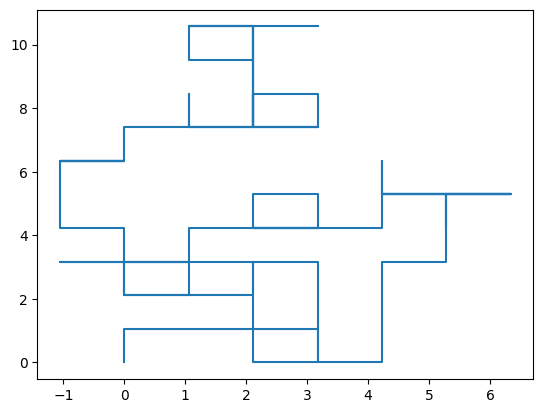

In [53]:
x, y = random_walk(random.PRNGKey(np.random.randint(0, 100)), time=100)
plt.plot(x, y)
plt.show()

# Every step is super variable in both magnitude and direction

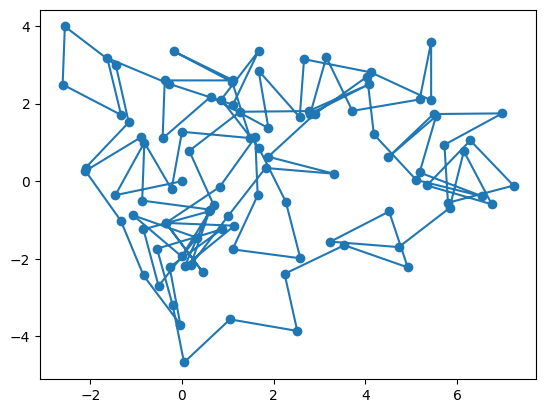

In [76]:
def random_direction_walk(key, time=10):
    key, stepsize_key = random.split(key)
    stepsize = truncated_normal(stepsize_key, mean = 1, std = 1)

    #getting a random angle for each step
    key, angle_key = random.split(key)
    angles = random.uniform(angle_key, shape=(time - 1,), minval=0.0, maxval=2 * jnp.pi)

    #movement vector
    steps = stepsize * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)

    positions = jnp.cumsum(steps, axis=0)
    positions = jnp.vstack([jnp.array([0.0, 0.0]), positions])
    x = positions[:, 0]
    y = positions[:, 1]

    return x, y

x, y = random_direction_walk(random.PRNGKey(np.random.randint(0, 100)), time=100)

plt.plot(x, y, marker='o')

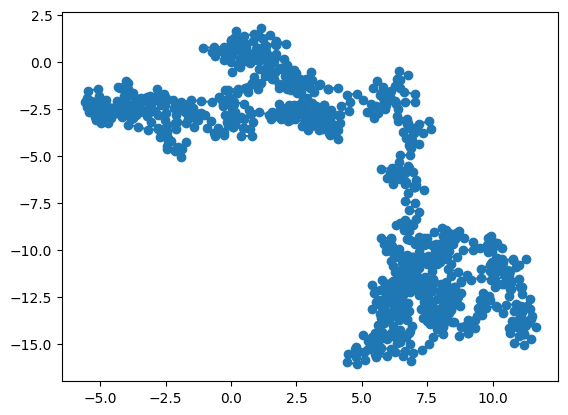

In [141]:
def random_direction_walk2(key, time=10):
    key, stepsize_key = random.split(key)
    samples = sample_sine_squared_vectorized(3, 3, 1000)
    stepsize = samples[np.random.randint(0, len(samples))]

    #getting a random angle for each step
    key, angle_key = random.split(key)
    angles = random.uniform(angle_key, shape=(time - 1,), minval=0.0, maxval=2 * jnp.pi)

    #movement vector
    steps = stepsize * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)

    positions = jnp.cumsum(steps, axis=0)
    positions = jnp.vstack([jnp.array([0.0, 0.0]), positions])
    x = positions[:, 0]
    y = positions[:, 1]

    return x, y

x, y = random_direction_walk2(random.PRNGKey(np.random.randint(0, 100)), time=1000)

plt.plot(x, y, marker='o')

Slope is: 0.47747288241612323


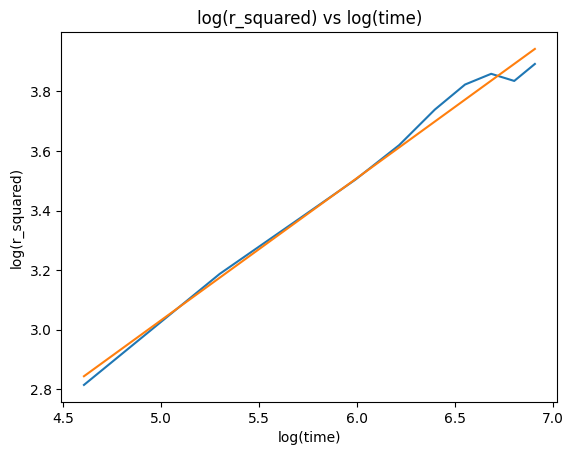

In [154]:
def random_direction_walk_only_last(key, time=10):
    key, stepsize_key = random.split(key)

    samples = sample_sine_squared_vectorized(3, 3, 1000)
    stepsize = samples[np.random.randint(0, len(samples))]

    key, angle_key = random.split(key)
    angles = random.uniform(angle_key, shape=(int(time - 1),), minval=0.0, maxval=2 * jnp.pi)
    steps = stepsize * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)

    positions = jnp.cumsum(steps, axis=0)
    last_position = positions[-1]

    return last_position[0], last_position[1]


N = 500
timerange = np.linspace(100, 1000, 10)
mean_r_squared = []
for t in timerange:
    r_squared_temp = 0
    for _ in range(N):
        x, y = random_direction_walk_only_last(random.PRNGKey(np.random.randint(0, 100)), time=t)
        r_squared_temp += (x**2 + y**2)/N
    mean_r_squared.append(r_squared_temp)
r_rms = np.sqrt(mean_r_squared)

log_timerange = np.log(timerange)
log_r_rms = np.log(r_rms)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_timerange, log_r_rms)

plt.plot(log_timerange, log_r_rms)
plt.plot(log_timerange, slope * log_timerange + intercept)
print("Slope is:", slope)
plt.xlabel('log(time)')
plt.ylabel('log(r_squared)')
plt.title('log(r_squared) vs log(time)')
plt.show()

# Non-uniform directions

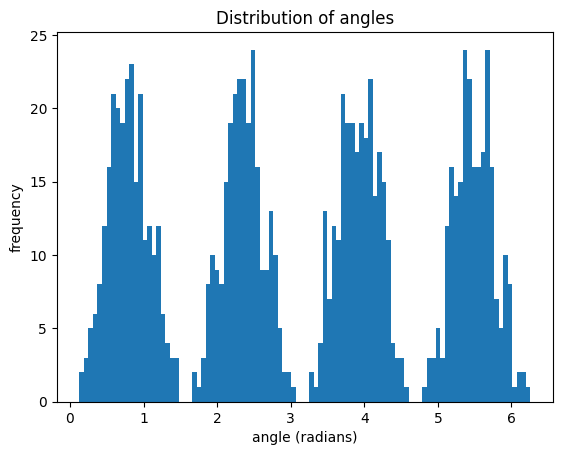

In [168]:
plt.hist(sample_sine_squared_vectorized(jnp.pi, 2*jnp.pi, 1000), bins=100)
plt.xlabel('angle (radians)')
plt.ylabel('frequency')
plt.title('Distribution of angles')
plt.show()

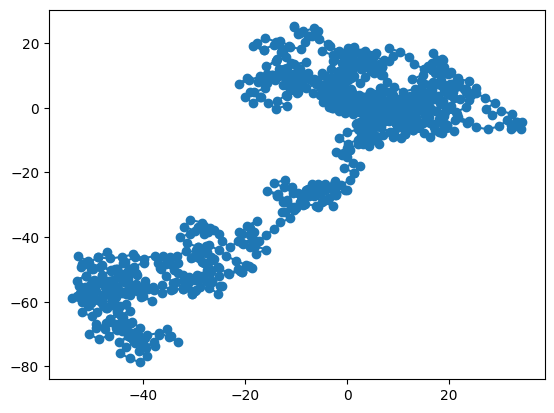

In [197]:
def random_direction_walk2(key, time=100):
    key, stepsize_key = random.split(key)
    samples = sample_sine_squared_vectorized(3, 3, 1000)
    stepsize = samples[np.random.randint(0, len(samples))]
    angles = sample_sine_squared_vectorized(jnp.pi, 2*jnp.pi, int(time - 1))
    steps = stepsize * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)

    positions = jnp.cumsum(steps, axis=0)
    positions = jnp.vstack([jnp.array([0.0, 0.0]), positions])
    x = positions[:, 0]
    y = positions[:, 1]

    return x, y

x, y = random_direction_walk2(random.PRNGKey(np.random.randint(0, 100)), time=1000)

plt.plot(x, y, marker='o')

Slope is: 0.4808866596059231


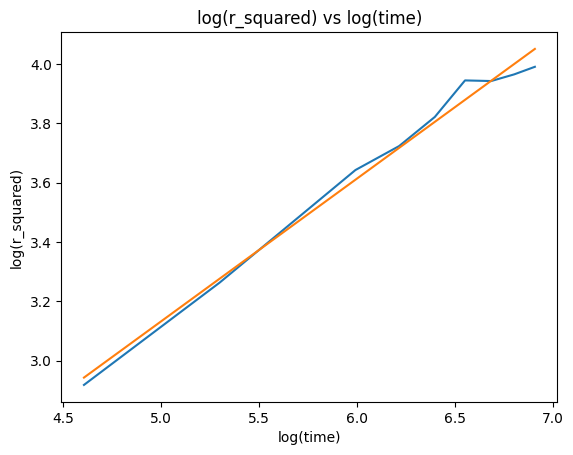

In [192]:
def non_uniform_direction_walk_only_last(key, time=10):
    key, stepsize_key = random.split(key)
    stepsize = truncated_normal(stepsize_key, mean = 1, std = 1)
    key, angle_key = random.split(key)
    angles = sample_sine_squared_vectorized(jnp.pi, 2*jnp.pi, int(time - 1))
    steps = stepsize * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)

    positions = jnp.cumsum(steps, axis=0)
    last_position = positions[-1]

    return last_position[0], last_position[1]

N = 500
timerange = np.linspace(100, 1000, 10)
mean_r_squared = []
for t in timerange:
    r_squared_temp = 0
    for _ in range(N):
        x, y = non_uniform_direction_walk_only_last(random.PRNGKey(np.random.randint(0, 100)), time=t)
        r_squared_temp += (x**2 + y**2)/N
    mean_r_squared.append(r_squared_temp)
r_rms = np.sqrt(mean_r_squared)

log_timerange = np.log(timerange)
log_r_rms = np.log(r_rms)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_timerange, log_r_rms)

plt.plot(log_timerange, log_r_rms)
plt.plot(log_timerange, slope * log_timerange + intercept)
print("Slope is:", slope)
plt.xlabel('log(time)')
plt.ylabel('log(r_squared)')
plt.title('log(r_squared) vs log(time)')
plt.show()